In [3]:
# # Лабораторная работа №4
# ## Классификация изображений: Круассан vs Рыжий кот

# **Цель работы:** Разработать программу для классификации изображений круассанов и рыжих котов с использованием сверточных нейронных сетей (CNN).

# **Задачи:**
# 1. Создать набор данных (минимум 20 изображений каждого класса)
# 2. Обучить две разные архитектуры CNN
# 3. Сравнить их эффективность
# 4. Визуализировать результаты

In [14]:
# Основные библиотеки
import sys
sys.path.append("/home/ahmedkashima/venv/lib/python3.12/site-packages")
# Импорт необходимых библиотек
import os  # Для работы с файловой системой
import numpy as np  # Для численных операций
import matplotlib.pyplot as plt  # Для визуализации
from sklearn.model_selection import train_test_split  # Для разделения данных
from sklearn.metrics import confusion_matrix, classification_report  # Для оценки модели
import seaborn as sns  # Для визуализации матрицы ошибок

# Библиотеки для работы с изображениями
from PIL import Image  # Для загрузки изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  # Для аугментации данных

# Библиотеки для построения модели
import tensorflow as tf
from tensorflow.keras.models import Sequential  # Последовательная модель
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # Слои CNN
from tensorflow.keras.optimizers import Adam  # Оптимизатор
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Коллбэки
from tensorflow.keras.utils import to_categorical  # Преобразование меток

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')
print("Доступные устройства:", tf.config.list_physical_devices('GPU'))


Доступные устройства: []


In [5]:
# Пути к папкам с изображениями
croissant_path = 'data/croissant/'  # Папка с круассанами
ginger_cat_path = 'data/ginger_cat/'  # Папка с рыжими котами

# Параметры изображений
IMG_WIDTH = 128  # Ширина изображения
IMG_HEIGHT = 128  # Высота изображения
CHANNELS = 3  # Цветовые каналы (RGB)

def load_images_from_folder(folder, label, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    """
    Загружает изображения из указанной папки и присваивает им метки
    
    Параметры:
        folder (str): Путь к папке с изображениями
        label (int): Метка класса (0 - круассан, 1 - рыжий кот)
        target_size (tuple): Размер, к которому нужно изменить изображение
        
    Возвращает:
        np.array: Массив изображений
        np.array: Массив меток
    """
    images = []
    labels = []
    for filename in os.listdir(folder):
        try:
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = img.resize(target_size)  # Изменение размера
            img_array = np.array(img)
            if img_array.shape == (target_size[0], target_size[1], CHANNELS):
                images.append(img_array)
                labels.append(label)
        except Exception as e:
            print(f"Ошибка загрузки {filename}: {e}")
    return np.array(images), np.array(labels)

# Загрузка изображений
croissant_images, croissant_labels = load_images_from_folder(croissant_path, 0)
cat_images, cat_labels = load_images_from_folder(ginger_cat_path, 1)

# Объединение данных
X = np.concatenate((croissant_images, cat_images))  # Объединяем изображения
y = np.concatenate((croissant_labels, cat_labels))  # Объединяем метки

# Нормализация данных (приведение к диапазону 0-1)
X = X.astype('float32') / 255.0

# Преобразование меток в one-hot encoding
y = to_categorical(y, num_classes=2)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% данных на тест
    random_state=42,  # Для воспроизводимости
    stratify=y  # Сохраняем распределение классов
)

print(f"Всего изображений: {len(X)}")
print(f"Обучающая выборка: {len(X_train)}")
print(f"Тестовая выборка: {len(X_test)}")

Всего изображений: 40
Обучающая выборка: 32
Тестовая выборка: 8


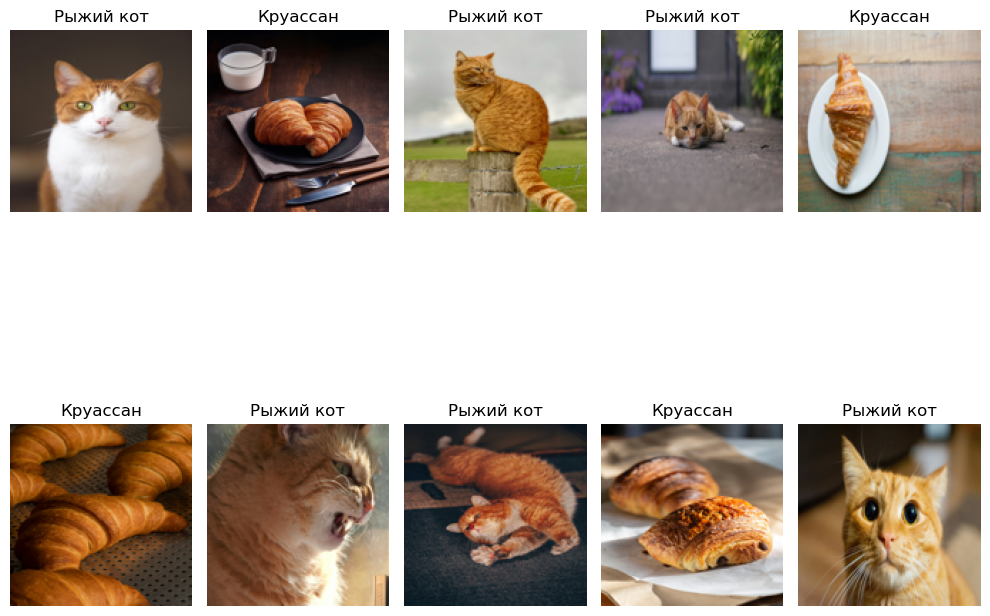

In [6]:
def plot_sample_images(images, labels, class_names, n=5):
    """
    Визуализирует примеры изображений с их метками
    
    Параметры:
        images (np.array): Массив изображений
        labels (np.array): Массив меток
        class_names (list): Названия классов
        n (int): Количество изображений для отображения
    """
    plt.figure(figsize=(10, 10))
    for i in range(n*2):
        plt.subplot(2, n, i+1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Названия классов
class_names = ['Круассан', 'Рыжий кот']
plot_sample_images(X_train, y_train, class_names)

In [15]:
# Первая модель - простая CNN
model1 = Sequential([
    # Сверточный слой с 32 фильтрами 3x3 и функцией активации ReLU
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS)),
    # Слой подвыборки (уменьшение размерности)
    MaxPooling2D((2, 2)),
    
    # Второй сверточный слой с 64 фильтрами
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Третий сверточный слой с 128 фильтрами
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Преобразование 2D данных в 1D
    Flatten(),
    # Полносвязный слой
    Dense(128, activation='relu'),
    # Слой регуляризации (для предотвращения переобучения)
    Dropout(0.5),
    # Выходной слой с softmax (2 класса)
    Dense(2, activation='softmax')
])

# Компиляция модели
model1.compile(
    optimizer=Adam(learning_rate=0.001),  # Оптимизатор Adam
    loss='categorical_crossentropy',  # Функция потерь
    metrics=['accuracy']  # Метрика - точность
)

# Вывод структуры модели
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4688 - loss: 0.7113 - val_accuracy: 0.5000 - val_loss: 0.7435 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step - accuracy: 0.6250 - loss: 0.6262 - val_accuracy: 0.5000 - val_loss: 0.9698 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step - accuracy: 0.5625 - loss: 0.8463 - val_accuracy: 0.5000 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.5938 - loss: 0.6445 - val_accuracy: 0.5000 - val_loss: 0.7534 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.5000 - loss: 0.6536 - val_accuracy: 0.5000 - val_loss: 0.7038 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step - accuracy: 0.5625 - loss: 0.6484 - val_accuracy: 0.3750 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 0.7812 - loss: 0.6110 - val_accuracy: 0.3

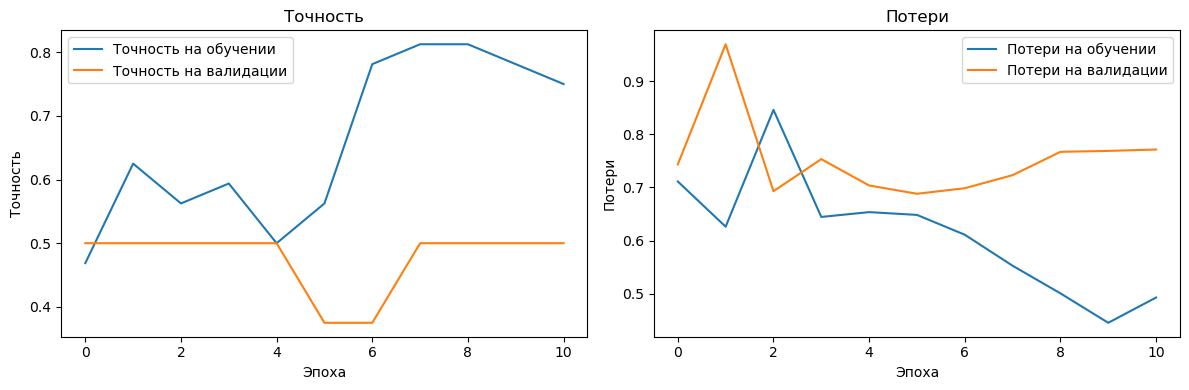

Модель 1 - Точность на тесте: 0.3750, Потери на тесте: 0.6882


In [16]:
# Параметры обучения
BATCH_SIZE = 32  # Размер мини-выборки (batch) для одного шага обучения
EPOCHS = 30  # Общее количество проходов по всему тренировочному набору данных (эпох)

# Коллбэк для ранней остановки обучения, если модель перестала улучшаться
early_stop = EarlyStopping(
    monitor='val_loss',  # Отслеживаем значение потерь на валидационной выборке
    patience=5,  # Количество эпох без улучшения, после которых обучение остановится
    restore_best_weights=True  # При завершении обучения будут восстановлены лучшие веса модели
)

# Коллбэк для уменьшения скорости обучения при отсутствии улучшения
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Отслеживаем значение потерь на валидации
    factor=0.2,  # Уменьшаем learning rate в 5 раз при ухудшении (1 * 0.2 = 0.2)
    patience=3,  # Количество эпох без улучшения до уменьшения learning rate
    min_lr=0.0001  # Нижняя граница значения learning rate
)

# Обучение модели
history1 = model1.fit(
    X_train, y_train,  # Обучающие данные
    batch_size=BATCH_SIZE,  # Размер мини-выборки
    epochs=EPOCHS,  # Количество эпох
    validation_data=(X_test, y_test),  # Набор данных для валидации на каждой эпохе
    callbacks=[early_stop, reduce_lr]  # Используемые коллбэки
)

# Функция для визуализации истории обучения модели
def plot_training_history(history):
    """
    Визуализирует процесс обучения модели
    
    Параметры:
        history: Объект истории обучения, возвращаемый model.fit()
    """
    plt.figure(figsize=(12, 4))  # Размер общего окна графика

    # График точности (accuracy)
    plt.subplot(1, 2, 1)  # Левая часть (1 строка, 2 столбца, 1-й график)
    plt.plot(history.history['accuracy'], label='Точность на обучении')  # Точность на тренировке
    plt.plot(history.history['val_accuracy'], label='Точность на валидации')  # Точность на валидации
    plt.title('Точность')
    plt.xlabel('Эпоха')  # Подпись оси X
    plt.ylabel('Точность')  # Подпись оси Y
    plt.legend()  # Отображение легенды

    # График потерь (loss)
    plt.subplot(1, 2, 2)  # Правая часть (1 строка, 2 столбца, 2-й график)
    plt.plot(history.history['loss'], label='Потери на обучении')  # Потери на тренировке
    plt.plot(history.history['val_loss'], label='Потери на валидации')  # Потери на валидации
    plt.title('Потери')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()

    # Автоматически корректирует расположение графиков, чтобы не было наложений
    plt.tight_layout()
    plt.show()

# Визуализация процесса обучения по истории history1
plot_training_history(history1)

# Оценка модели на тестовых данных
loss1, accuracy1 = model1.evaluate(X_test, y_test, verbose=0)  # Вычисление финальных метрик
print(f"Модель 1 - Точность на тесте: {accuracy1:.4f}, Потери на тесте: {loss1:.4f}")


In [9]:
# Вторая модель — более сложная сверточная нейронная сеть (CNN) с нормализацией батчей (BatchNormalization)
model2 = Sequential([
    # Первый сверточный слой: 32 фильтра размером 3x3, функция активации ReLU
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS)),
    BatchNormalization(),  # Нормализация активаций для ускорения и стабилизации обучения
    MaxPooling2D((2, 2)),  # Подвыборка, уменьшающая пространственные размеры в 2 раза
    Dropout(0.2),  # Регуляризация — случайное "выключение" 20% нейронов для предотвращения переобучения

    # Второй сверточный блок: 64 фильтра 3x3, ReLU
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),  # BatchNorm для стабилизации распределения признаков
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Выключение 30% нейронов

    # Третий сверточный блок: 128 фильтров 3x3, ReLU
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),  # 40% dropout для сильной регуляризации

    # Четвертый сверточный блок: 256 фильтров 3x3, ReLU
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),  # 50% dropout — половина нейронов выключается

    # "Выпрямление" (преобразование 3D-тензора в 1D-вектор)
    Flatten(),

    # Полносвязный слой с 256 нейронами и активацией ReLU
    Dense(256, activation='relu'),
    BatchNormalization(),  # BatchNorm для стабилизации входов к следующему слою
    Dropout(0.5),  # Dropout для предотвращения переобучения

    # Выходной слой с 2 нейронами (количество классов) и активацией softmax для вероятностей классов
    Dense(2, activation='softmax')
])

# Компиляция модели: определение оптимизатора, функции потерь и метрик для оценки
model2.compile(
    optimizer=Adam(learning_rate=0.0005),  # Оптимизатор Adam с небольшой скоростью обучения
    loss='categorical_crossentropy',  # Функция потерь для многоклассовой классификации (one-hot)
    metrics=['accuracy']  # Метрика точности для оценки качества модели
)

# Вывод структуры модели (слои, параметры)
model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,426 (10.50 MB)

 Trainable params: 2,749,954 (10.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5625 - loss: 0.9493 - val_accuracy: 0.5000 - val_loss: 0.7043 - learning_rate: 5.0000e-04
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.8204 - val_accuracy: 0.5000 - val_loss: 0.7004 - learning_rate: 5.0000e-04
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7812 - loss: 0.6291 - val_accuracy: 0.5000 - val_loss: 0.6884 - learning_rate: 5.0000e-04
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8125 - loss: 0.3732 - val_accuracy: 0.7500 - val_loss: 0.6785 - learning_rate: 5.0000e-04
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9375 - loss: 0.3983 - val_accuracy: 0.5000 - val_loss: 0.6779 - learning_rate: 5.0000e-04
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8438 - loss: 0.3476 - val_accuracy: 0.5000 - val_loss: 0.6877 - learning_rate: 5.0000e-04
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 0.3054 - val_accurac

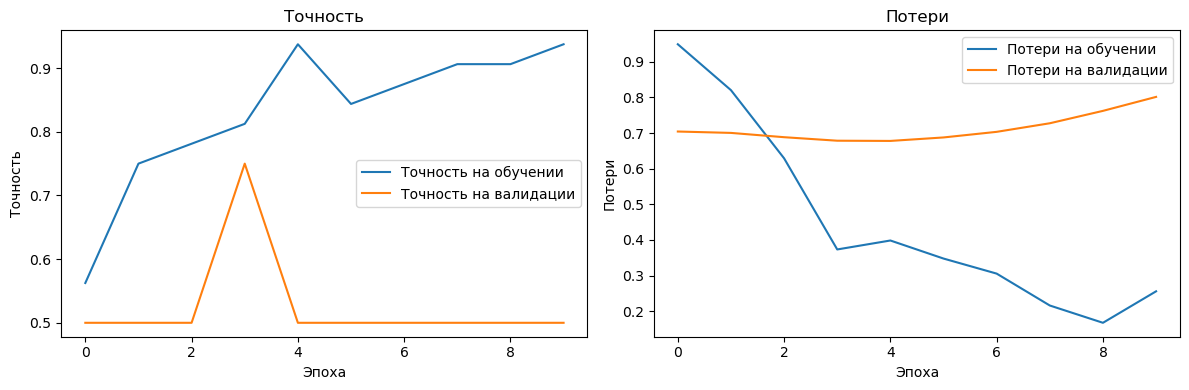

Модель 2 - Точность на тесте: 0.5000, Потери на тесте: 0.6779


In [10]:
# Обучение второй модели
history2 = model2.fit(
    X_train,              # Обучающие данные (входы)
    y_train,              # Обучающие данные (цели/метки)
    batch_size=BATCH_SIZE,  # Размер батча для пакетной обработки
    epochs=EPOCHS,          # Количество проходов по всему обучающему набору
    validation_data=(X_test, y_test),  # Валидационный набор для контроля переобучения
    callbacks=[early_stop, reduce_lr]  # Обратные вызовы: остановка по раннему признаку и уменьшение learning rate
)

# Визуализация процесса обучения: графики точности и потерь по эпохам
plot_training_history(history2)

# Оценка качества модели на тестовых данных (без вывода прогресса)
loss2, accuracy2 = model2.evaluate(X_test, y_test, verbose=0)

# Вывод результатов оценки модели на тесте: точность и значение функции потерь
print(f"Модель 2 - Точность на тесте: {accuracy2:.4f}, Потери на тесте: {loss2:.4f}")


Результаты Модели 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


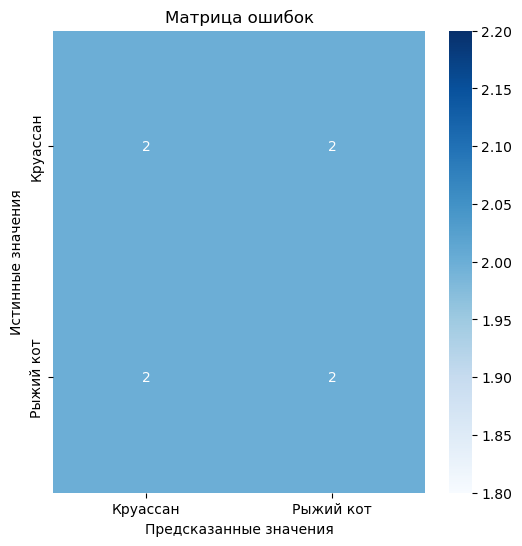

              precision    recall  f1-score   support

    Круассан       0.50      0.50      0.50         4
   Рыжий кот       0.50      0.50      0.50         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.50         8
weighted avg       0.50      0.50      0.50         8


Результаты Модели 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


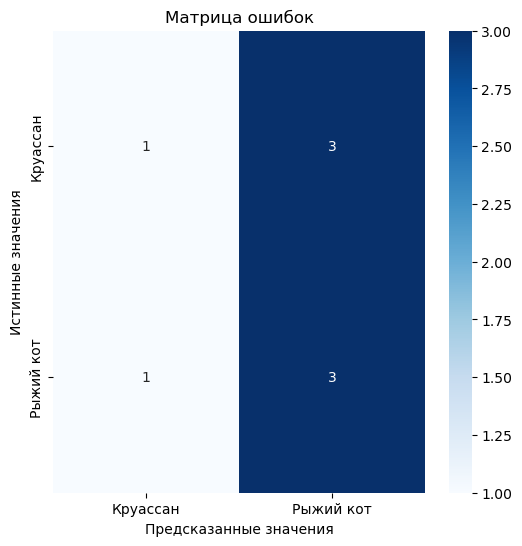

              precision    recall  f1-score   support

    Круассан       0.50      0.25      0.33         4
   Рыжий кот       0.50      0.75      0.60         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8



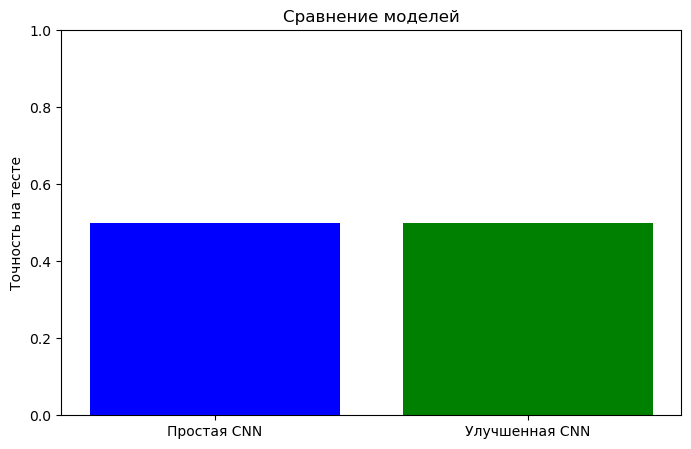

In [11]:
def plot_confusion_matrix(model, X_test, y_test, class_names):
    """
    Строит матрицу ошибок для модели
    
    Параметры:
        model: Обученная модель
        X_test: Тестовые изображения
        y_test: Тестовые метки (one-hot encoded)
        class_names: Список названий классов для осей матрицы ошибок
    """
    # Получение предсказаний модели на тестовых данных
    y_pred = model.predict(X_test)
    
    # Преобразование вероятностей предсказаний в классы (индексы с максимальной вероятностью)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Получение истинных классов из one-hot кодировки меток
    y_true = np.argmax(y_test, axis=1)
    
    # Вычисление матрицы ошибок (confusion matrix)
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Визуализация матрицы ошибок с помощью тепловой карты seaborn
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,  # Названия классов по оси X (предсказанные)
                yticklabels=class_names)  # Названия классов по оси Y (истинные)
    plt.title('Матрица ошибок')
    plt.ylabel('Истинные значения')
    plt.xlabel('Предсказанные значения')
    plt.show()
    
    # Вывод подробного отчёта по классификации с метриками precision, recall, f1-score
    print(classification_report(y_true, y_pred_classes, target_names=class_names))


# Вывод результатов для первой модели
print("Результаты Модели 1:")
plot_confusion_matrix(model1, X_test, y_test, class_names)

# Вывод результатов для второй модели
print("\nРезультаты Модели 2:")
plot_confusion_matrix(model2, X_test, y_test, class_names)

# Сравнение точности обеих моделей на тестовом наборе с помощью столбчатой диаграммы
plt.figure(figsize=(8, 5))
plt.bar(['Простая CNN', 'Улучшенная CNN'], [accuracy1, accuracy2], color=['blue', 'green'])
plt.title('Сравнение моделей')
plt.ylabel('Точность на тесте')
plt.ylim(0, 1)  # Ограничение оси Y от 0 до 1 для удобства восприятия
plt.show()


Тестирование Модели 2 на новых изображениях:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


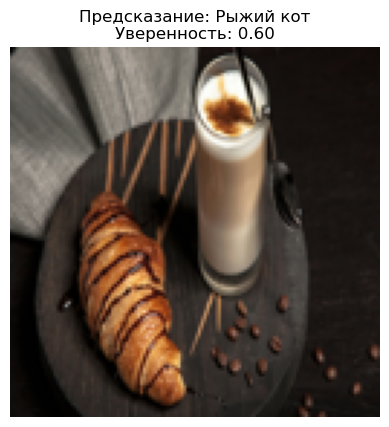

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


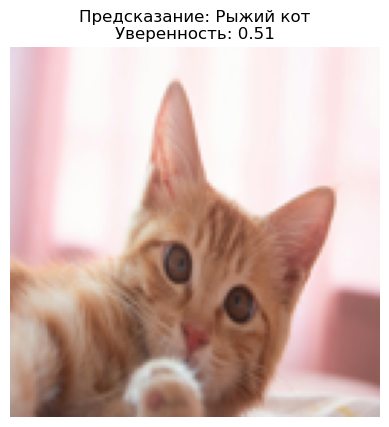

In [12]:
def predict_new_image(model, image_path, class_names):
    """
    Предсказывает класс для нового изображения
    
    Параметры:
        model: Обученная модель
        image_path: Путь к изображению
        class_names: Список названий классов
    """
    # Открываем изображение с помощью PIL
    img = Image.open(image_path).convert('RGB')  # Приводим к RGB, чтобы избежать проблем с каналами
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))   # Изменяем размер под вход модели
    
    # Преобразуем изображение в массив numpy
    img_array = np.array(img)
    
    # Проверяем форму изображения (высота, ширина, каналы)
    if img_array.shape == (IMG_HEIGHT, IMG_WIDTH, CHANNELS):  # Важно: порядок (высота, ширина, каналы)
        # Нормализация значений пикселей в диапазон [0,1]
        img_array = img_array.astype('float32') / 255.0
        
        # Добавляем измерение батча (1, H, W, C)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Получаем предсказание от модели (вероятности классов)
        prediction = model.predict(img_array)
        
        # Индекс класса с максимальной вероятностью
        predicted_index = np.argmax(prediction)
        
        # Имя предсказанного класса
        predicted_class = class_names[predicted_index]
        
        # Уверенность модели (максимальная вероятность)
        confidence = np.max(prediction)
        
        # Визуализация изображения с подписью результата
        plt.imshow(img)
        plt.title(f"Предсказание: {predicted_class}\nУверенность: {confidence:.2f}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Некорректные размеры изображения: ожидалось {(IMG_HEIGHT, IMG_WIDTH, CHANNELS)}, получено {img_array.shape}")

# Пример использования (замените пути на свои изображения)
test_cat = "test_images/test_cat.jpg"
test_croissant = "test_images/test_croissant.jpg"

print("Тестирование Модели 2 на новых изображениях:")
predict_new_image(model2, test_croissant, class_names)
predict_new_image(model2, test_cat, class_names)
